对于每个方程形式，改变参数观察training loss和error变化情况

In [16]:
# Cell 1: 环境和库导入

import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import time

from net_pbc import PhysicsInformedNN_pbc, DNN
from systems_pbc import convection_diffusion, reaction_diffusion_discrete_solution, reaction_solution
from systems_pbc import function
from utils import set_seed, sample_random


In [17]:
# Cell 2: 定义辅助函数，封装训练与测试逻辑

def train_and_evaluate_pinn(system='convection',
                            nu=0.0,
                            beta=1.0,
                            rho=0.0,
                            N_f=100,
                            layers_str='50,50,50,50,1',
                            lr=1.0,
                            L=1.0,
                            activation='tanh',
                            optimizer_name='LBFGS',
                            seed=0):
    """
    封装了对单次训练的完整流程（相当于 main_pbc.py 的精简版），返回：
      - final_train_loss: 训练结束时的总损失 (loss_u + loss_b + L * loss_f)
      - error_u_rel: 测试相对误差
    参数含义与 main_pbc.py 中类似
    """
    # 1. 设置随机种子
    set_seed(seed)

    # 2. 生成/加载训练数据（x_u,t_u为初值，x_f,t_f为PDE内部点，bc_lb,bc_ub为边界）
    xgrid = 256  # 固定空间网格数
    nt = 100     # 固定时间网格数
    x = np.linspace(0, 2*np.pi, xgrid, endpoint=False).reshape(-1, 1)
    t_arr = np.linspace(0, 1, nt).reshape(-1, 1)
    
    # 根据system类型修正nu, beta, rho, 并构造真解
    if system == 'diffusion':
        beta = 0.0
        rho = 0.0
    elif system == 'convection':
        nu = 0.0
        rho = 0.0
    elif system == 'rd':  # reaction-diffusion
        beta = 0.0
    elif system == 'reaction':
        nu = 0.0
        beta = 0.0

    # 用 systems_pbc 里的函数获取真解
    if 'convection' in system or 'diffusion' in system:
        u_vals = convection_diffusion('sin(x)', nu, beta, 0, xgrid, nt)
    elif system == 'rd':
        u_vals = reaction_diffusion_discrete_solution('sin(x)', nu, rho, xgrid, nt)
    elif system == 'reaction':
        u_vals = reaction_solution('sin(x)', rho, xgrid, nt)
    else:
        raise ValueError("未定义的 system 类型：", system)
    
    # 整理成测试集 (X_star, u_star)
    X, T = np.meshgrid(x, t_arr)
    X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
    u_star = u_vals.reshape(-1, 1)
    
    # 构造初值和边界
    Exact = u_star.reshape(nt, xgrid)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))  # 初值所在 (t=0)
    uu1 = Exact[0:1,:].T                      # t=0时刻的u
    bc_lb = np.hstack((X[:,0:1], T[:,0:1]))    # x=0 边界
    bc_ub = np.hstack((np.array([2*np.pi]*nt).reshape(-1, 1), t_arr))

    # 选择内点（排除初值和边界），用于 PDE 残差
    t_noinitial = t_arr[1:]
    x_noboundary = x[1:]
    X_noboundary, T_noinitial = np.meshgrid(x_noboundary, t_noinitial)
    X_star_noinitial_noboundary = np.hstack((X_noboundary.flatten()[:, None], 
                                             T_noinitial.flatten()[:, None]))
    X_f_train = sample_random(X_star_noinitial_noboundary, N_f)
    
    # 3. 实例化 PINN 并训练
    # 解析网络层
    layers = [int(item) for item in layers_str.split(',')]
    layers.insert(0, 2)  # 输入(x, t)两维
    
    # G 代表可能存在的强制项/源项，这里为0
    G = np.full(X_f_train.shape[0], 0.0)
    
    # 准备 PhysicsInformedNN
    model = PhysicsInformedNN_pbc(system, 
                                  X_u_train=xx1, u_train=uu1,
                                  X_f_train=X_f_train, 
                                  bc_lb=bc_lb, bc_ub=bc_ub,
                                  layers=layers, 
                                  G=G, nu=nu, beta=beta, rho=rho,
                                  optimizer_name=optimizer_name, lr=lr,
                                  net='DNN', L=L, activation=activation, 
                                  loss_style='mean')
    
    # 使用LBFGS时，模型会在一次step内进行多次迭代，这里只调一次step并打印
    # 如果希望更多迭代，可循环多次 step(model.train())，这里简化
    model.train()
    
    # 4. 拟合结束后，计算训练损失
    final_train_loss = model.loss_pinn(verbose=False).item()
    
    # 5. 预测并计算测试误差
    u_pred = model.predict(X_star)
    error_u_rel = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

    return final_train_loss, error_u_rel


epoch 0, gradient: 8.90174e-01, loss: 5.08086e-01, loss_u: 5.06934e-01, loss_b: 7.62808e-04, loss_f: 3.89023e-04
epoch 100, gradient: 6.58157e-01, loss: 1.03081e-02, loss_u: 5.60865e-03, loss_b: 9.49749e-04, loss_f: 3.74972e-03
epoch 200, gradient: 1.04406e-01, loss: 1.77007e-04, loss_u: 8.91260e-05, loss_b: 7.97133e-06, loss_f: 7.99093e-05
epoch 0, gradient: 8.90107e-01, loss: 5.08120e-01, loss_u: 5.06934e-01, loss_b: 7.62808e-04, loss_f: 4.23261e-04
epoch 100, gradient: 3.58877e-01, loss: 7.91192e-03, loss_u: 5.00970e-03, loss_b: 4.51988e-04, loss_f: 2.45023e-03
epoch 200, gradient: 1.02419e-01, loss: 3.31678e-04, loss_u: 9.85065e-05, loss_b: 4.44170e-05, loss_f: 1.88754e-04
epoch 0, gradient: 8.90363e-01, loss: 5.08126e-01, loss_u: 5.06934e-01, loss_b: 7.62808e-04, loss_f: 4.28721e-04
epoch 100, gradient: 2.45956e+00, loss: 6.84928e-03, loss_u: 3.07128e-03, loss_b: 1.59268e-03, loss_f: 2.18532e-03
epoch 200, gradient: 9.10947e-02, loss: 2.27701e-04, loss_u: 5.90438e-05, loss_b: 4.85

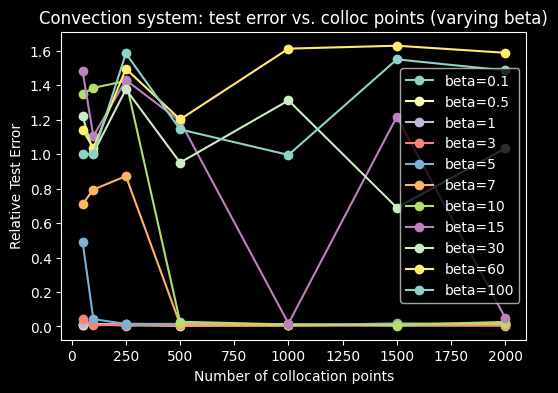

In [18]:
# Cell 3: 对 “convection” 系统的实验：批量扫描 beta, collocation point

# 扫多种 beta 和 N_f
beta_list_convection = [0.1, 0.5, 1, 3, 5, 7, 10, 15, 30, 60, 100]
colloc_list = [50, 100, 250, 500, 1000, 1500, 2000]

results_convection = {}  # 用于保存 (beta, colloc) 对应的 (train_loss, test_rel_error)

# 批量训练
for beta_val in beta_list_convection:
    for N_f_val in colloc_list:
        train_loss, test_loss = train_and_evaluate_pinn(system='convection',
                                                        nu=0.0, 
                                                        beta=beta_val, 
                                                        rho=0.0,
                                                        N_f=N_f_val,
                                                        layers_str='50,50,50,50,1',
                                                        lr=1.0,
                                                        L=1.0,
                                                        activation='tanh',
                                                        optimizer_name='LBFGS',
                                                        seed=0)
        results_convection[(beta_val, N_f_val)] = (train_loss, test_loss)

# 绘图：对 collocation point 作 x 轴，分别画出不同 beta 时的 test_loss 曲线

plt.figure(figsize=(6,4))
for beta_val in beta_list_convection:
    test_losses = []
    for N_f_val in colloc_list:
        _, t_loss = results_convection[(beta_val, N_f_val)]
        test_losses.append(t_loss)
    plt.plot(colloc_list, test_losses, marker='o', label=f"beta={beta_val}")
plt.xlabel("Number of collocation points")
plt.ylabel("Relative Test Error")
plt.legend()
plt.title("Convection system: test error vs. colloc points (varying beta)")
plt.show()

epoch 0, gradient: 9.25406e-01, loss: 5.08741e-01, loss_u: 5.06934e-01, loss_b: 1.41404e-03, loss_f: 3.92489e-04
epoch 100, gradient: 2.09563e-01, loss: 6.44317e-03, loss_u: 1.27028e-03, loss_b: 1.77964e-03, loss_f: 3.39324e-03
epoch 200, gradient: 8.49719e-02, loss: 2.42847e-04, loss_u: 4.62802e-05, loss_b: 1.86958e-05, loss_f: 1.77871e-04
epoch 0, gradient: 9.25405e-01, loss: 5.08772e-01, loss_u: 5.06934e-01, loss_b: 1.41404e-03, loss_f: 4.24348e-04
epoch 100, gradient: 1.34938e+00, loss: 1.25047e-02, loss_u: 3.28631e-03, loss_b: 2.10336e-03, loss_f: 7.11504e-03
epoch 200, gradient: 3.74734e-02, loss: 9.74023e-04, loss_u: 2.20555e-04, loss_b: 3.91910e-05, loss_f: 7.14277e-04
epoch 300, gradient: 6.31483e-02, loss: 2.36125e-04, loss_u: 1.02036e-04, loss_b: 4.13497e-05, loss_f: 9.27393e-05
epoch 0, gradient: 9.25659e-01, loss: 5.08779e-01, loss_u: 5.06934e-01, loss_b: 1.41404e-03, loss_f: 4.30716e-04
epoch 100, gradient: 2.37513e-01, loss: 1.52679e-02, loss_u: 5.17582e-03, loss_b: 3.01

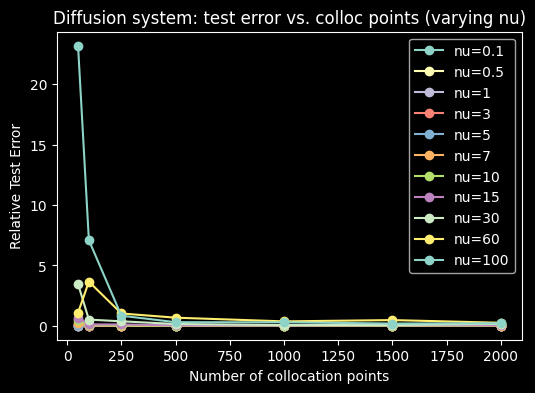

In [19]:
# Cell 4: 对 “diffusion” 系统的实验：批量扫描 nu, collocation point

nu_list_diffusion = [0.1, 0.5, 1, 3, 5, 7, 10, 15, 30, 60, 100]
colloc_list = [50, 100, 250, 500, 1000, 1500, 2000]

results_diffusion = {}

for nu_val in nu_list_diffusion:
    for N_f_val in colloc_list:
        train_loss, test_loss = train_and_evaluate_pinn(system='diffusion',
                                                        nu=nu_val, 
                                                        beta=0.0, 
                                                        rho=0.0,
                                                        N_f=N_f_val,
                                                        layers_str='50,50,50,50,1',
                                                        lr=1.0,
                                                        L=1.0,
                                                        activation='tanh',
                                                        optimizer_name='LBFGS',
                                                        seed=0)
        results_diffusion[(nu_val, N_f_val)] = (train_loss, test_loss)

# 可视化
plt.figure(figsize=(6,4))
for nu_val in nu_list_diffusion:
    test_losses = []
    for N_f_val in colloc_list:
        _, t_loss = results_diffusion[(nu_val, N_f_val)]
        test_losses.append(t_loss)
    plt.plot(colloc_list, test_losses, marker='o', label=f"nu={nu_val}")
plt.xlabel("Number of collocation points")
plt.ylabel("Relative Test Error")
plt.legend()
plt.title("Diffusion system: test error vs. colloc points (varying nu)")
plt.show()

epoch 0, gradient: 8.99586e-01, loss: 5.08418e-01, loss_u: 5.06934e-01, loss_b: 7.62808e-04, loss_f: 7.20801e-04
epoch 100, gradient: 3.82065e-01, loss: 4.81832e-03, loss_u: 2.16076e-03, loss_b: 6.92170e-04, loss_f: 1.96539e-03
epoch 200, gradient: 7.78028e-01, loss: 3.71584e-04, loss_u: 1.34148e-04, loss_b: 1.00963e-04, loss_f: 1.36473e-04
epoch 0, gradient: 8.99719e-01, loss: 5.08468e-01, loss_u: 5.06934e-01, loss_b: 7.62808e-04, loss_f: 7.70685e-04
epoch 100, gradient: 2.11551e-01, loss: 8.80076e-03, loss_u: 3.61940e-03, loss_b: 7.03875e-04, loss_f: 4.47748e-03
epoch 200, gradient: 4.08823e-01, loss: 4.40400e-04, loss_u: 1.08675e-04, loss_b: 2.62647e-05, loss_f: 3.05460e-04
epoch 0, gradient: 9.00116e-01, loss: 5.08476e-01, loss_u: 5.06934e-01, loss_b: 7.62808e-04, loss_f: 7.78737e-04
epoch 100, gradient: 8.72096e-01, loss: 7.58643e-03, loss_u: 4.66414e-03, loss_b: 9.08922e-04, loss_f: 2.01337e-03
epoch 200, gradient: 7.15755e-02, loss: 2.51539e-04, loss_u: 2.06093e-05, loss_b: 3.97

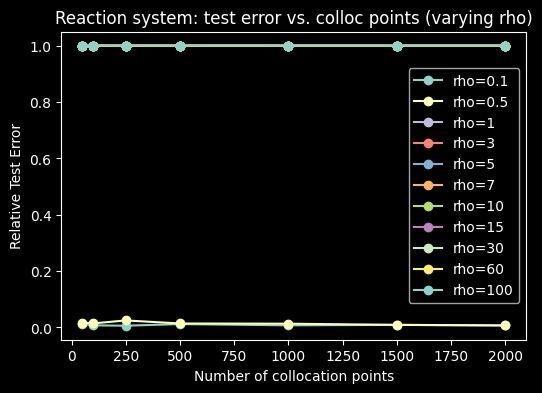

In [20]:
# Cell 5: 对 “reaction” 系统的实验：批量扫描 rho, collocation point

rho_list_reaction = [0.1, 0.5, 1, 3, 5, 7, 10, 15, 30, 60, 100]
colloc_list = [50, 100, 250, 500, 1000, 1500, 2000]

results_reaction = {}

for rho_val in rho_list_reaction:
    for N_f_val in colloc_list:
        train_loss, test_loss = train_and_evaluate_pinn(system='reaction',
                                                        nu=0.0, 
                                                        beta=0.0, 
                                                        rho=rho_val,
                                                        N_f=N_f_val,
                                                        layers_str='50,50,50,50,1',
                                                        lr=1.0,
                                                        L=1.0,
                                                        activation='tanh',
                                                        optimizer_name='LBFGS',
                                                        seed=0)
        results_reaction[(rho_val, N_f_val)] = (train_loss, test_loss)

# 可视化
plt.figure(figsize=(6,4))
for rho_val in rho_list_reaction:
    test_losses = []
    for N_f_val in colloc_list:
        _, t_loss = results_reaction[(rho_val, N_f_val)]
        test_losses.append(t_loss)
    plt.plot(colloc_list, test_losses, marker='o', label=f"rho={rho_val}")
plt.xlabel("Number of collocation points")
plt.ylabel("Relative Test Error")
plt.legend()
plt.title("Reaction system: test error vs. colloc points (varying rho)")
plt.show()

epoch 0, gradient: 9.33855e-01, loss: 5.09100e-01, loss_u: 5.06934e-01, loss_b: 1.41404e-03, loss_f: 7.52342e-04
epoch 100, gradient: 1.37963e+00, loss: 1.27459e-02, loss_u: 3.12407e-03, loss_b: 3.44165e-03, loss_f: 6.18016e-03
epoch 200, gradient: 2.28166e-01, loss: 1.10215e-03, loss_u: 4.02809e-04, loss_b: 6.02553e-05, loss_f: 6.39082e-04
epoch 0, gradient: 9.33530e-01, loss: 5.09114e-01, loss_u: 5.06934e-01, loss_b: 1.41404e-03, loss_f: 7.66140e-04
epoch 100, gradient: 1.45171e+00, loss: 1.15053e-02, loss_u: 3.19418e-03, loss_b: 1.83820e-03, loss_f: 6.47289e-03
epoch 200, gradient: 2.13847e-01, loss: 1.28913e-03, loss_u: 2.68060e-04, loss_b: 1.38147e-04, loss_f: 8.82921e-04
epoch 300, gradient: 5.95634e-02, loss: 3.93923e-04, loss_u: 4.31457e-05, loss_b: 8.01777e-05, loss_f: 2.70600e-04
epoch 400, gradient: 9.11310e-03, loss: 2.94394e-04, loss_u: 5.43552e-05, loss_b: 4.02149e-05, loss_f: 1.99824e-04
epoch 500, gradient: 1.63569e-02, loss: 2.41459e-04, loss_u: 6.25554e-05, loss_b: 2.

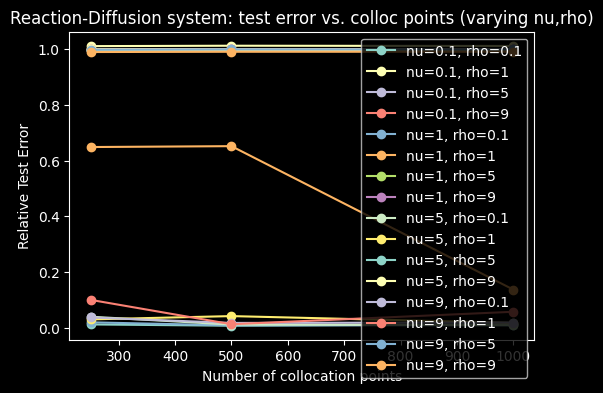

In [21]:
# Cell 6: 对 “rd” (reaction-diffusion) 系统的实验：批量扫描 nu, rho, collocation point

nu_list_rd = [0.1, 1, 5, 9]
rho_list_rd = [0.1, 1, 5, 9]
colloc_list = [250, 500, 1000]

results_rd = {}

for nu_val in nu_list_rd:
    for rho_val in rho_list_rd:
        for N_f_val in colloc_list:
            train_loss, test_loss = train_and_evaluate_pinn(system='rd',
                                                            nu=nu_val, 
                                                            beta=0.0, 
                                                            rho=rho_val,
                                                            N_f=N_f_val,
                                                            layers_str='50,50,50,50,1',
                                                            lr=1.0,
                                                            L=1.0,
                                                            activation='tanh',
                                                            optimizer_name='LBFGS',
                                                            seed=0)
            results_rd[(nu_val, rho_val, N_f_val)] = (train_loss, test_loss)

#将 colloc_points 作为 x轴，每组 (nu, rho) 绘一条曲线
plt.figure(figsize=(6,4))
for nu_val in nu_list_rd:
    for rho_val in rho_list_rd:
        test_losses = []
        for N_f_val in colloc_list:
            _, t_loss = results_rd[(nu_val, rho_val, N_f_val)]
            test_losses.append(t_loss)
        plt.plot(colloc_list, test_losses, marker='o', label=f"nu={nu_val}, rho={rho_val}")
plt.xlabel("Number of collocation points")
plt.ylabel("Relative Test Error")
plt.legend()
plt.title("Reaction-Diffusion system: test error vs. colloc points (varying nu,rho)")
plt.show()